### BERT Fine tuning for sentiment analysis


BERT: It is a tranformer architecture model proposed in: <a href="https://arxiv.org/abs/1810.04805">BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding</a>. By this method, we can pre-train general purpose language model and then fine tune it for a given task. BERT takes unlabled text 
as input, mask out 15% words, and tries to predict these words. Masked sentences propogates through transformer architecture. BERT Model also takes care of the relationship between sentences, by training a simple task of predicting, whether the given sentence (in BERT input) is next to previous sentence or not. 


In this excercise:
- I fine tuned BERT *bert-base-uncased* by following the below steps
- Took the data set, cleaned and preprocessed it for sentiment task.
- Converted sentences into BERT Model input by using the BERT Tokenizer.
- I took 128 as the max length of tokens for BERT Layer input.
- If the sentence falls to less size, it has been right padded, if it is more then truncated.
- After all this whole model follows the below architecture.

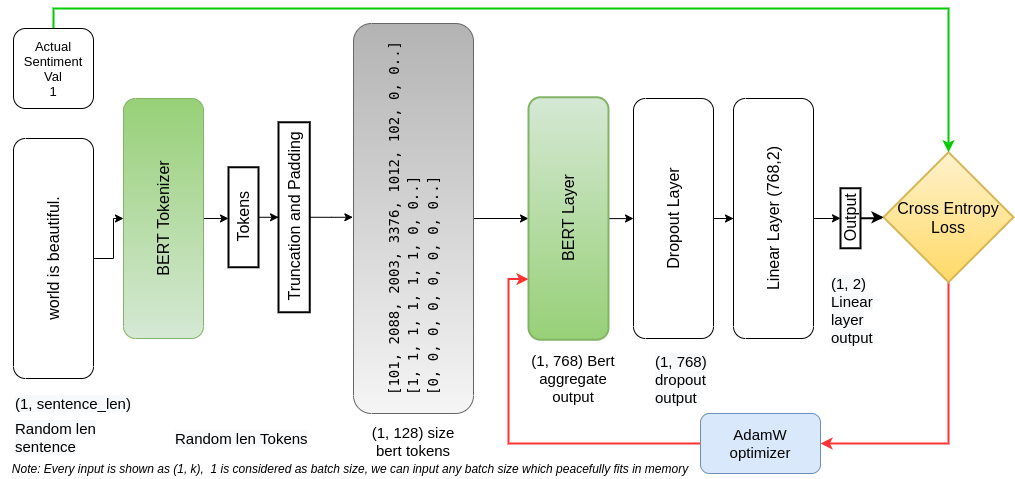

In [1]:
from IPython.display import Image
Image(filename='../input/bert-sentiment-architecture/sentiment_arch_generalised.png')

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [3]:
data = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)
data.columns = ('target','uid', 'time', 'query', 'user', 'text')

In [4]:
data.head(3)

,target,uid,time,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...


In [5]:
def preprocess_text(tweet):
    tweet = tweet.lower()
    # replace links with 'url'
    tweet = re.sub(r'((https?:\/\/)|(www\.))[A-Za-z0-9.\/]+', 'url',  tweet)
    tweet = re.sub(r'[A-Za-z0-9]+.com', 'url',tweet)
    # remove , @users, if any
    tweet = re.sub(r'[@][A-Za-z0-9]+', '',tweet)
    # remove non-ascii characters
    tweet = ''.join([w for w in tweet if ord(w)<128])
    #get hastags
    """
    # bert tokenizer takes care of such tokens, which have some punctuation attached to it
    # hastags will be taken care of 
    tags = ' '.join([w.strip("#") for w in tweet.split() if w.startswith("#")])
    tweet = re.sub(r'[#][A-Za-z0-9]+', '',tweet)
    """
    tweet = tweet.strip()
    # return tweet, tags
    return tweet

In [6]:
# Creating processed dataframe
sent_df = pd.DataFrame(None, columns=('target', 'text'))
sent_df['target'] = data['target']
sent_df['text'] = data['text'].apply(preprocess_text)
sent_df['tweet_size'] = data['text'].apply(lambda x:len(x.split()))

In [7]:
sent_df.head(3)

,target,text,tweet_size
0,0,"url - awww, that's a bummer. you shoulda got ...",19
1,0,is upset that he can't update his facebook by ...,21
2,0,i dived many times for the ball. managed to sa...,18


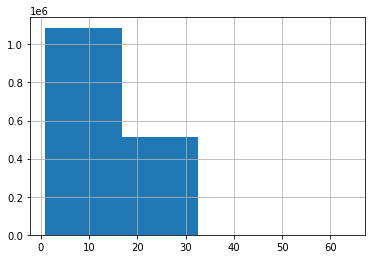

In [8]:
sent_df['tweet_size'].hist(bins = 4)

In [9]:
# max tweet size
np.max(sent_df['tweet_size'])

64

In [10]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW
from transformers import get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [11]:
class SentConfig():
    """
    Constants, config used during the project.
    """
    BERT_PRETRAINED = 'bert-base-uncased'
    TOKENIZER = BertTokenizer.from_pretrained(BERT_PRETRAINED)
    BERT_HIDDEN_SIZE = 768
    MAX_TOKENS_LEN = 128
    TRAIN_BATCH_SIZE = 64
    VALID_BATCH_SIZE = 32
    EPOCHS = 3
    SEED = 10

In [12]:
# Select random subset of 3L samples, 1.50L from each category. Also tweets must have more than 10 words in it. 

sent_df_sample = sent_df[(sent_df['tweet_size']>10) & (sent_df['target']==0)].sample(n=250000, random_state=SentConfig.SEED)
sent_df_sample = sent_df_sample.append(sent_df[(sent_df['tweet_size']>10) & (sent_df['target']==4)].sample(n=250000, random_state=SentConfig.SEED))


In [13]:
class SentimentDL():
    """
    DataLoader class, it employs mechanishm of tokenisation using bert, truncation and padding .
    :param modified_df: any dataframe train, test, validataion
    :return: DataLoader type object for the provided dataframe
    """
    def __init__(self, modified_df):
        self.mdf = modified_df
    
    def __len__(self):
        return self.mdf.shape[0]
    
    def __getitem__(self, index_num):
        """
        :return: dictionary of the BERT Tokenizer representaion, and the corresponding sentiment represented in long tensor (target varible)
        """
        row = self.mdf.iloc[index_num]
        tweet = row['text']
        target = 0 if int(row['target']) is 0 else 1
        # {0:'positive class', 1:'negative class'}
    
        tw_bert_tok = SentConfig.TOKENIZER(tweet)

        tw_input_ids = tw_bert_tok['input_ids']
        tw_mask = tw_bert_tok['attention_mask']
        tw_tt_ids = tw_bert_tok['token_type_ids']
    
        len_ = len(tw_input_ids)
        if len_ > SentConfig.MAX_TOKENS_LEN:
          tw_input_ids = tw_input_ids[:SentConfig.MAX_TOKENS_LEN-1]+[102]
          tw_mask = tw_mask[:SentConfig.MAX_TOKENS_LEN]
          tw_tt_ids = tw_tt_ids[:SentConfig.MAX_TOKENS_LEN]
        elif len_ < SentConfig.MAX_TOKENS_LEN:
          pad_len = SentConfig.MAX_TOKENS_LEN - len_
          tw_input_ids = tw_input_ids + ([0] * pad_len)
          tw_mask = tw_mask + ([0] * pad_len)
          tw_tt_ids = tw_tt_ids + ([0] * pad_len)
        return {
            'input_ids':torch.tensor(tw_input_ids, dtype=torch.long),
            'attention_mask':torch.tensor(tw_mask, dtype=torch.long),
            'token_type_ids':torch.tensor(tw_tt_ids, dtype=torch.long),
            'target':torch.tensor(target, dtype=torch.long)
        }

In [14]:
# get train, test, validation set from our preprocessed sample of 3L.

train, test = train_test_split(sent_df_sample, test_size=0.1)
train, val = train_test_split(train, test_size=0.05)

In [15]:
# create necessary data loader objects

train_dl = SentimentDL(train)
val_dl = SentimentDL(val)
test_dl = SentimentDL(test)

train_loader = DataLoader(train_dl, batch_size=SentConfig.TRAIN_BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(val_dl, batch_size=SentConfig.VALID_BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dl, batch_size=SentConfig.VALID_BATCH_SIZE, shuffle=True)

In [16]:
class SentimentModel(nn.Module):
    def __init__(self):
        super(SentimentModel, self).__init__()
        self.bert = BertModel.from_pretrained(SentConfig.BERT_PRETRAINED)
        self.drop_out = nn.Dropout(0.30)  # more dropout value for regularisation
        self.linear1 = nn.Linear(SentConfig.BERT_HIDDEN_SIZE, 2)
    
    def forward(self, input_ids, attention_mask, tt_ids):
        """
        This is forward step of our model. It takes, BERT Tokenizer generated representation of sentence, 
        and passes it through the bert -> dropout -> linear layers repectively.
    
        Note: out_ = token wise output (ignored) from the bert layer, as in our task (sentiment analysis) we need aggregated output 
        """
        out_, pooled_out = self.bert(input_ids, attention_mask, tt_ids)
        out = self.drop_out(pooled_out)
        out = self.linear1(out)
        return out

In [17]:
# get device type and accordingly move generated, model object to device.

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = SentimentModel()
model.to(device)

SentimentModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

#### Little intro to Loss, optimizer, scheduler
- Loss : This project uses CrossEntropyLoss, It is multiclass loss calculation function. It basically comes from logarithmic loss defination:  <span class="MathJax" id="MathJax-Element-4-Frame" tabindex="0" style="text-align: center; position: relative;" data-mathml="<math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot; display=&quot;block&quot;><mo>&amp;#x2212;</mo><munderover><mo>&amp;#x2211;</mo><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>c</mi><mo>=</mo><mn>1</mn></mrow><mi>M</mi></munderover><msub><mi>y</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>o</mi><mo>,</mo><mi>c</mi></mrow></msub><mi>log</mi><mo>&amp;#x2061;</mo><mo stretchy=&quot;false&quot;>(</mo><msub><mi>p</mi><mrow class=&quot;MJX-TeXAtom-ORD&quot;><mi>o</mi><mo>,</mo><mi>c</mi></mrow></msub><mo stretchy=&quot;false&quot;>)</mo></math>" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-35" style="width: 8.87em; display: inline-block;"><span style="display: inline-block; position: relative; width: 7.588em; height: 0px; font-size: 117%;"><span style="position: absolute; clip: rect(0.377em, 1007.48em, 3.582em, -999.997em); top: -2.241em; left: 0em;"><span class="mrow" id="MathJax-Span-36"><span class="mo" id="MathJax-Span-37" style="font-family: MathJax_Main;">−</span><span class="munderover" id="MathJax-Span-38" style="padding-left: 0.163em;"><span style="display: inline-block; position: relative; width: 1.445em; height: 0px;"><span style="position: absolute; clip: rect(2.887em, 1001.39em, 4.597em, -999.997em); top: -4.004em; left: 0em;"><span class="mo" id="MathJax-Span-39" style="font-family: MathJax_Size2; vertical-align: 0em;">∑</span><span style="display: inline-block; width: 0px; height: 4.009em;"></span></span><span style="position: absolute; clip: rect(3.368em, 1001.18em, 4.276em, -999.997em); top: -2.935em; left: 0.11em;"><span class="texatom" id="MathJax-Span-40"><span class="mrow" id="MathJax-Span-41"><span class="mi" id="MathJax-Span-42" style="font-size: 70.7%; font-family: MathJax_Math; font-style: italic;">c</span><span class="mo" id="MathJax-Span-43" style="font-size: 70.7%; font-family: MathJax_Main;">=</span><span class="mn" id="MathJax-Span-44" style="font-size: 70.7%; font-family: MathJax_Main;">1</span></span></span><span style="display: inline-block; width: 0px; height: 4.009em;"></span></span><span style="position: absolute; clip: rect(3.261em, 1000.75em, 4.169em, -999.997em); top: -5.179em; left: 0.377em;"><span class="mi" id="MathJax-Span-45" style="font-size: 70.7%; font-family: MathJax_Math; font-style: italic;">M<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.056em;"></span></span><span style="display: inline-block; width: 0px; height: 4.009em;"></span></span></span></span><span class="msubsup" id="MathJax-Span-46" style="padding-left: 0.163em;"><span style="display: inline-block; position: relative; width: 1.392em; height: 0px;"><span style="position: absolute; clip: rect(3.421em, 1000.48em, 4.383em, -999.997em); top: -4.004em; left: 0em;"><span class="mi" id="MathJax-Span-47" style="font-family: MathJax_Math; font-style: italic;">y<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span style="display: inline-block; width: 0px; height: 4.009em;"></span></span><span style="position: absolute; top: -3.843em; left: 0.483em;"><span class="texatom" id="MathJax-Span-48"><span class="mrow" id="MathJax-Span-49"><span class="mi" id="MathJax-Span-50" style="font-size: 70.7%; font-family: MathJax_Math; font-style: italic;">o</span><span class="mo" id="MathJax-Span-51" style="font-size: 70.7%; font-family: MathJax_Main;">,</span><span class="mi" id="MathJax-Span-52" style="font-size: 70.7%; font-family: MathJax_Math; font-style: italic;">c</span></span></span><span style="display: inline-block; width: 0px; height: 4.009em;"></span></span></span></span><span class="mi" id="MathJax-Span-53" style="font-family: MathJax_Main; padding-left: 0.163em;">log</span><span class="mo" id="MathJax-Span-54"></span><span class="mo" id="MathJax-Span-55" style="font-family: MathJax_Main;">(</span><span class="msubsup" id="MathJax-Span-56"><span style="display: inline-block; position: relative; width: 1.445em; height: 0px;"><span style="position: absolute; clip: rect(3.421em, 1000.48em, 4.383em, -999.997em); top: -4.004em; left: 0em;"><span class="mi" id="MathJax-Span-57" style="font-family: MathJax_Math; font-style: italic;">p</span><span style="display: inline-block; width: 0px; height: 4.009em;"></span></span><span style="position: absolute; top: -3.843em; left: 0.483em;"><span class="texatom" id="MathJax-Span-58"><span class="mrow" id="MathJax-Span-59"><span class="mi" id="MathJax-Span-60" style="font-size: 70.7%; font-family: MathJax_Math; font-style: italic;">o</span><span class="mo" id="MathJax-Span-61" style="font-size: 70.7%; font-family: MathJax_Main;">,</span><span class="mi" id="MathJax-Span-62" style="font-size: 70.7%; font-family: MathJax_Math; font-style: italic;">c</span></span></span><span style="display: inline-block; width: 0px; height: 4.009em;"></span></span></span></span><span class="mo" id="MathJax-Span-63" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.246em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -1.434em; border-left: 0px solid; width: 0px; height: 3.566em;"></span></span></nobr><span class="MJX_Assistive_MathML MJX_Assistive_MathML_Block" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><mo>−</mo><munderover><mo>∑</mo><mrow class="MJX-TeXAtom-ORD"><mi>c</mi><mo>=</mo><mn>1</mn></mrow><mi>M</mi></munderover><msub><mi>y</mi><mrow class="MJX-TeXAtom-ORD"><mi>o</mi><mo>,</mo><mi>c</mi></mrow></msub><mi>log</mi><mo>⁡</mo><mo stretchy="false">(</mo><msub><mi>p</mi><mrow class="MJX-TeXAtom-ORD"><mi>o</mi><mo>,</mo><mi>c</mi></mrow></msub><mo stretchy="false">)</mo></math></span></span>
- More on Loss: <a href="https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html">Cross Entropy Loss</a>

- Optimizer: AdamW: Adam optimizer with weight decay. Algo used for optimizing weights of the network. More on Optimizer : <a href="https://huggingface.co/transformers/main_classes/optimizer_schedules.html">AdamW</a>

- Scheduler: cosine_scheduler_with_warmup: It will constantly change the learning rate on train steps, according to the cosine function after warm up (some specified) steps. More on scheduler: <a href="https://huggingface.co/transformers/_modules/transformers/optimization.html#get_cosine_schedule_with_warmup">Cosine scheduler</a>

In [18]:

loss_function = nn.CrossEntropyLoss()


# Adam optimizer with weight decay AdamW from transformers
# do not apply weight decay in AdamW  to, bias layer and normalization terms
no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.bias']  # taken from https://huggingface.co/transformers/training.html 
# more named parameteres in model.named_parameters()
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

# optimizer object
optim = AdamW(optimizer_grouped_parameters, lr=4e-5)

# learning rate scheduling
num_train_steps = int((train_dl.__len__()/SentConfig.TRAIN_BATCH_SIZE)*SentConfig.EPOCHS)
num_warmup_steps = int(0.05*num_train_steps)
scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps, num_train_steps)

In [19]:
def train_function(data_loader, model, optimizer, scheduler, device):
    """
    Function to train single epoch on the data accessible with data_loader
    """
    epoch_loss = 0
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        target = batch['target'].to(device)

        outputs = model(input_ids, attention_mask, token_type_ids)

        batch_loss = loss_function(outputs, target)
        batch_loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += batch_loss.item()
    epoch_loss = epoch_loss / len(data_loader)
    return epoch_loss


def evaluation_function(data_loader, model, device, inference=False):
    """
    Function to evaluate current model performance.
    """
    epoch_loss = 0
    model.eval()
    results = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            target = batch['target'].to(device)

            outputs = model(input_ids, attention_mask, token_type_ids)
#             if not inference:
            batch_loss = loss_function(outputs, target)
            epoch_loss += batch_loss.item()
#             else:
            outputs = torch.argmax(outputs, dim=1).to('cpu').numpy()
            target = target.to('cpu').numpy()
            results.extend(list(zip(outputs, target)))
    epoch_loss = epoch_loss / len(data_loader)
    return epoch_loss, np.array(results)

In [20]:
%%time

# Training : done on the basis of validation loss vs training loss
scores = []
min_f1 = 0

for epoch in range(SentConfig.EPOCHS):
  _ = train_function(train_loader, model, optim, scheduler, device)
  _, results = evaluation_function(validation_loader, model, device)
  validation_f1 = round(f1_score(results[:,1], results[:,0]),4)
  accuracy = round(accuracy_score(results[:,1], results[:,0]), 4)
  
  print('epoch num: ', epoch, 'f1 score: ',validation_f1 , 'accuracy: ', accuracy)
  scores.append((validation_f1, accuracy))

  if validation_f1 > min_f1:
        # save  model if validation f1 score is 
        torch.save(model.state_dict(), "SentimentModel5L.bin")
        # update max loss
        min_f1 =  validation_f1

epoch num:  0 f1 score:  0.8481 accuracy:  0.8517
epoch num:  1 f1 score:  0.8567 accuracy:  0.8588
epoch num:  2 f1 score:  0.8513 accuracy:  0.8536
CPU times: user 2h 52min 29s, sys: 1h 29min 27s, total: 4h 21min 56s
Wall time: 4h 23min 48s


Text(0.5, 1.0, 'validation set accuracy at each apoch')

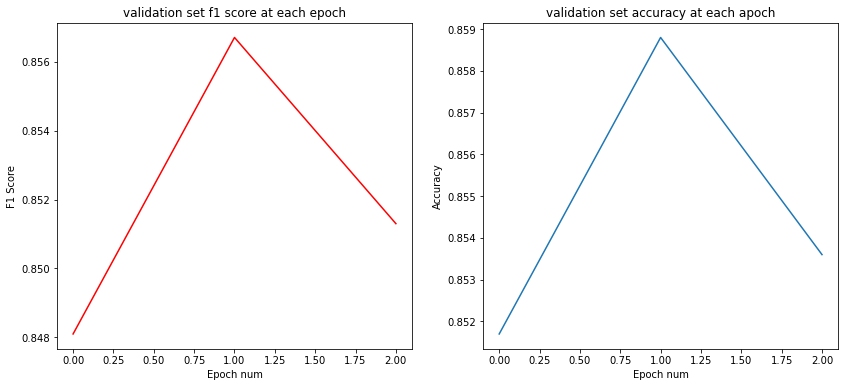

In [21]:
# plotting losses

scores = np.array(scores)
fig, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].plot(range(SentConfig.EPOCHS), scores[:,0], 'r')
ax[1].plot(range(SentConfig.EPOCHS), scores[:,1])
ax[0].set(xlabel='Epoch num', ylabel='F1 Score')
ax[1].set(xlabel='Epoch num', ylabel='Accuracy')
ax[0].set_title('validation set f1 score at each epoch')
ax[1].set_title('validation set accuracy at each apoch')

In [22]:
# Load model from the trained saved model
state_dict_ = torch.load('SentimentModel5L.bin')
model = SentimentModel()
model.load_state_dict(state_dict_)
model.to(device)

# Calculate F1 score report
_, results = evaluation_function(test_loader, model, device, inference=True)
print(classification_report(results[:,1], results[:,0]))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86     25125
           1       0.86      0.84      0.85     24875

    accuracy                           0.85     50000
   macro avg       0.85      0.85      0.85     50000
weighted avg       0.85      0.85      0.85     50000



In [23]:
print(round(accuracy_score(results[:,1], results[:,0]),4))

0.8541


Thanks to Transformers !! :) 